# Imports

In [ ]:
import sys
sys.path.insert(0, '..')


import numpy as np
from scipy import stats

from DB_connection import DB_connection
from diversity_metrics import compute_user_entropy, compute_user_recommended_diversity, shanon_entropy, compute_user_diversity_evolution, compute_user_pref


db_connection = DB_connection()


## Usefull functions

In [ ]:
def compute_pairwise_statistical_significance(dict):
    keys = list(dict.keys())
    for i in range(len(keys)):
        for j in range(len(keys)):
            if i < j:
                key1 = keys[i]
                key2 = keys[j]
                tvalue, pvalue = stats.ttest_ind(dict[key1], dict[key2])
                print(f"Comparing {key1:<11}  and {key2:<11} : p-value = {pvalue}")

def cronbach_alpha(data):
    items = data.shape[1]
    item_variances = data.var(axis=0, ddof=1)
    total_variance = data.sum(axis=1).var(ddof=1)
    alpha = (items / (items - 1)) * (1 - (item_variances.sum() / total_variance))
    return alpha


# 1. Diversity 

## 1.1. Consumed Diversity

In [36]:
users_by_rs = db_connection.get_users_by_RS()
recommendation_systems = users_by_rs.keys()

consumed_diversities_dict = dict()
mean_consumed_diversities_dict = dict()


for rs in recommendation_systems:
    consumed_diversities = []
   
    for user_id in users_by_rs[rs]:
        user_pref = compute_user_pref(user_id)
        user_pref = [float(p) for p in user_pref]
        entropy_user_pref = shanon_entropy(user_pref)
        consumed_diversities.append(compute_user_entropy(user_id)-entropy_user_pref)
           
    consumed_diversities_dict[rs] = consumed_diversities
    mean_consumed_diversities_dict[rs] = float(np.mean(consumed_diversities))

print("Mean consumed diversities for each RS:")
print(mean_consumed_diversities_dict)

print(" ")
print("Pairwise statistical significance for consumed diversities:")
compute_pairwise_statistical_significance(consumed_diversities_dict)
  

Mean consumed diversities for each RS:
{'SVD': -0.014856734221075116, 'MMR': -0.008806676166025257, 'PI-adaptDiv': 0.05395753774378324, 'EDC': 0.13096070949611754}
 
Pairwise statistical significance for consumed diversities:
Comparing SVD          and MMR         : p-value = 0.8852772267713933
Comparing SVD          and PI-adaptDiv : p-value = 0.07481703721910103
Comparing SVD          and EDC         : p-value = 0.00022808297746113417
Comparing MMR          and PI-adaptDiv : p-value = 0.06553038691078435
Comparing MMR          and EDC         : p-value = 5.217223459003382e-05
Comparing PI-adaptDiv  and EDC         : p-value = 0.006250814610517748


## 1.2. Recommended Diversity

In [ ]:
users_by_rs = db_connection.get_users_by_RS()
recommendation_systems = users_by_rs.keys()

recommended_diversities_dict = dict()
mean_recommended_diversities_dict = dict()


for rs in recommendation_systems:
    recommended_diversities = []
   
    for user_id in users_by_rs[rs]:
        recommended_diversities.append(compute_user_recommended_diversity(user_id))
           
    recommended_diversities_dict[rs] = recommended_diversities
    mean_recommended_diversities_dict[rs] = float(np.mean(recommended_diversities))

print("Mean Recommended diversities for each RS:")
print(mean_recommended_diversities_dict)

print(" ")
print("Pairwise statistical significance for recommended diversities:")
compute_pairwise_statistical_significance(recommended_diversities_dict)

Mean consumed diversities for each RS:
{'SVD': 0.9004757381882205, 'MMR': 0.9567431082355601, 'PI-adaptDiv': 0.8940760899612328, 'EDC': 0.9454359530424176}
 
Pairwise statistical significance for consumed diversities:
Comparing SVD          and MMR         : p-value = 8.518901767099905e-07
Comparing SVD          and PI-adaptDiv : p-value = 0.7184607373028657
Comparing SVD          and EDC         : p-value = 0.0001500767484907311
Comparing MMR          and PI-adaptDiv : p-value = 0.0002069413864776718
Comparing MMR          and EDC         : p-value = 0.08680460146427861
Comparing PI-adaptDiv  and EDC         : p-value = 0.0026358881592459683


## 1.3. User Perceived diversity

In [ ]:
user_perceived_div_dic = dict()
mean_user_perceived_div_dic = dict()
for rs in recommendation_systems:


    user_perceived_div_list = []
    for user_id in users_by_rs[rs]:
        query = f"SELECT * FROM user WHERE id ={user_id} "
        user = db_connection.select(query)
        m = (user["q2_answer"][0] - user["q3_answer"][0] + user["q5_answer"][0])/3
        user_perceived_div_list.append(m)
    user_perceived_div_dic[rs] = user_perceived_div_list
    mean_user_perceived_div_dic[rs] = float(np.mean(user_perceived_div_list))

print("Mean user perceived diversities for each RS:")
print(mean_user_perceived_div_dic)
print(" ")
print("Pairwise statistical significance for user perceived diversities:")
compute_pairwise_statistical_significance(user_perceived_div_dic)


Mean user perceived diversities for each RS:
{'SVD': 0.9855072463768116, 'MMR': 1.391304347826087, 'PI-adaptDiv': 1.2133333333333334, 'EDC': 1.1304347826086956}
 
Pairwise statistical significance for user perceived diversities:
Comparing SVD          and MMR         : p-value = 0.10409963242082707
Comparing SVD          and PI-adaptDiv : p-value = 0.34832275853722594
Comparing SVD          and EDC         : p-value = 0.6050037203028922
Comparing MMR          and PI-adaptDiv : p-value = 0.17060813788272325
Comparing MMR          and EDC         : p-value = 0.1533031489477533
Comparing PI-adaptDiv  and EDC         : p-value = 0.6478578160148937


### 1.3.1. Chronbach alpha diversity questions

In [41]:
diversity_questions_df = db_connection.select(f"SELECT q2_answer,q3_answer,q5_answer FROM user WHERE q2_answer NOT NULL")
diversity_questions_df['q3_answer'] = diversity_questions_df['q3_answer'] * -1

print(f"Cronbach alpha for diversity related questions : {cronbach_alpha(diversity_questions_df)}")


Cronbach alpha for diversity related questions : 0.8494048320565702


# 2. Quality

## 2.1. Average rating change : $\Delta\bar{r}$

In [44]:
users_by_rs = db_connection.get_users_by_RS()
recommendation_systems = users_by_rs.keys()

ratings_dict = dict()
mean_ratings_dict = dict()

for rs in recommendation_systems:

    ratings = []
    for user_id in users_by_rs[rs]:

        ratings_cold_start = db_connection.get_user_ratings(user_id)[0]
        ratings_experiment = db_connection.get_user_ratings(user_id)[1]
        ratings.append((float(np.mean(ratings_experiment))-float(np.mean(ratings_cold_start)))/float(np.mean(ratings_cold_start+ratings_experiment) ))
   
    ratings_dict[rs] = ratings
    mean_ratings_dict[rs] = float(np.mean(ratings))

print("Mean ratings for each RS:")
print(mean_ratings_dict)
print(" ")
print("Pairwise statistical significance for ratings:")
compute_pairwise_statistical_significance(ratings_dict)


Mean ratings for each RS:
{'SVD': 0.09579667044357451, 'MMR': 0.09631885365819562, 'PI-adaptDiv': 0.11256262978606507, 'EDC': -0.0003263253312428742}
 
Pairwise statistical significance for ratings:
Comparing SVD          and MMR         : p-value = 0.993043538045776
Comparing SVD          and PI-adaptDiv : p-value = 0.78703682838287
Comparing SVD          and EDC         : p-value = 0.06062201852386858
Comparing MMR          and PI-adaptDiv : p-value = 0.8065859879534105
Comparing MMR          and EDC         : p-value = 0.08884128206924478
Comparing PI-adaptDiv  and EDC         : p-value = 0.058405086677762404


## 2.2. Probability no choice

In [46]:
user_nbr_no_choice_dic = dict()
user_nbr_no_choice_mean_dic = dict()
for rs in recommendation_systems:
    user_nbr_no_choice_list = []
    for user_id in users_by_rs[rs]:
        query = f"SELECT * FROM behavior WHERE user_id={user_id} AND chosen_item is NULL"
        user_behavior = db_connection.select(query)
        user_nbr_no_choice_list.append(len(user_behavior))
    user_nbr_no_choice_dic[rs] = user_nbr_no_choice_list
    user_nbr_no_choice_mean_dic[rs] = float(np.mean(user_nbr_no_choice_list))

print("Mean number of no choice for each RS:")
print(user_nbr_no_choice_mean_dic)
print(" ")
print("Pairwise statistical significance for number of no choice:")
compute_pairwise_statistical_significance(user_nbr_no_choice_dic)

Mean number of no choice for each RS:
{'SVD': 11.08695652173913, 'MMR': 12.608695652173912, 'PI-adaptDiv': 19.0, 'EDC': 17.47826086956522}
 
Pairwise statistical significance for number of no choice:
Comparing SVD          and MMR         : p-value = 0.657694256588141
Comparing SVD          and PI-adaptDiv : p-value = 0.10146781001611392
Comparing SVD          and EDC         : p-value = 0.17946458416410127
Comparing MMR          and PI-adaptDiv : p-value = 0.16562065373568266
Comparing MMR          and EDC         : p-value = 0.2815581174518696
Comparing PI-adaptDiv  and EDC         : p-value = 0.7825827832933604


## 2.3. User perceived quality

In [47]:
user_perceived_quality_dic = dict()
mean_user_perceived_quality_dic = dict()
for rs in recommendation_systems:
    user_perceived_quality_list = []
    for user_id in users_by_rs[rs]:
        query = f"SELECT * FROM user WHERE id ={user_id} "
        user = db_connection.select(query)
        m = (user["q1_answer"][0] + user["q4_answer"][0] + user["q6_answer"][0]+ user["q7_answer"][0]+ user["q8_answer"][0])/5
        user_perceived_quality_list.append(m)
    user_perceived_quality_dic[rs] = user_perceived_quality_list
    mean_user_perceived_quality_dic[rs] = float(np.mean(user_perceived_quality_list))

print("Mean user perceived quality for each RS:")
print(mean_user_perceived_quality_dic)
print(" ")
print("Pairwise statistical significance for user perceived quality:")
compute_pairwise_statistical_significance(user_perceived_quality_dic)

Mean user perceived quality for each RS:
{'SVD': 0.9478260869565218, 'MMR': 0.8173913043478261, 'PI-adaptDiv': 0.784, 'EDC': -0.2339130434782609}
 
Pairwise statistical significance for user perceived quality:
Comparing SVD          and MMR         : p-value = 0.5939567530572368
Comparing SVD          and PI-adaptDiv : p-value = 0.525713022482702
Comparing SVD          and EDC         : p-value = 0.0003280308370634218
Comparing MMR          and PI-adaptDiv : p-value = 0.8902402950294724
Comparing MMR          and EDC         : p-value = 0.0007182913990208283
Comparing PI-adaptDiv  and EDC         : p-value = 0.0012913241004558465


### 2.3.1. Cronbach alpha for quality questions

In [48]:
quality_questions_df = db_connection.select(f"SELECT q1_answer,q4_answer,q6_answer,q7_answer,q8_answer  FROM user WHERE q1_answer NOT NULL")
print(f"Cronbach alpha for quality related questions : {cronbach_alpha(quality_questions_df)}")

Cronbach alpha for quality related questions : 0.9470512920081847


# 3. Quality VS Diversity

Text(0, 0.5, 'Quality($\\Delta r)$')

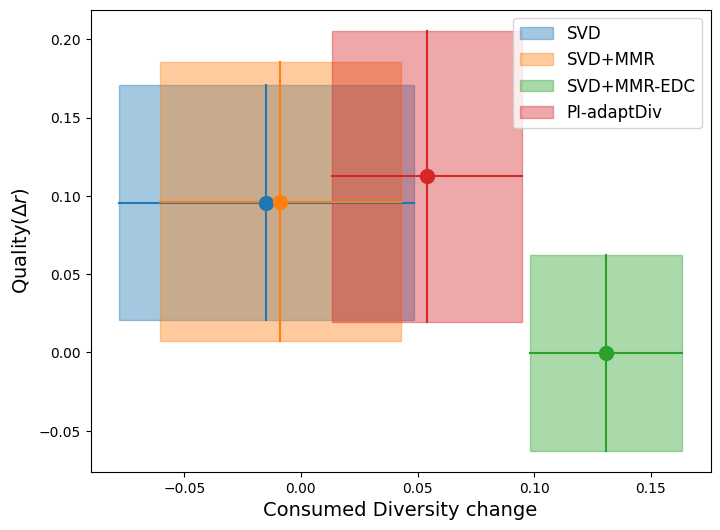

In [49]:
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib import rcParams
import matplotlib.pyplot as plt
default_colors = rcParams['axes.prop_cycle'].by_key()['color']

def confidence_interval_2D(x, y, ax, whis=1.5, color=None, label=None,xlabel = None, ylabel = None):
    # Ensure x and y are NumPy arrays
    x = np.asarray(x)
    y = np.asarray(y)

    mean_x = np.mean(x, axis=0)
    CI_x = stats.sem(x, axis=0) * 1.96

    mean_y = np.mean(y, axis=0)
    CI_y = stats.sem(y, axis=0)* 1.96
    
    ax.plot([mean_x], [mean_y], color=color, marker='o', markersize = 10)

    box = Rectangle(
        (mean_x - CI_x, mean_y-CI_y), 2*CI_x, 2*CI_y,
        edgecolor=color,
        facecolor=color,
        alpha=0.4,
        zorder=0,
        label=label  # Add the label here for the legend
    )
    ax.add_patch(box)

        ## The x median
    vline = Line2D(
       [ mean_x,mean_x], [mean_y -CI_y, mean_y +CI_y],
        color=color,
        zorder=1
    )
    ax.add_line(vline)

    ## The y median
    hline = Line2D(
        [mean_x-CI_x, mean_x + CI_x], [mean_y, mean_y],
        color=color,
        zorder=1
    )
    ax.add_line(hline)
    ax.set_xlabel(xlabel,fontsize = 14)
    ax.set_ylabel(ylabel, fontsize =14)



fig, ax = plt.subplots(figsize=(8, 6))

confidence_interval_2D(consumed_diversities_dict["SVD"],ratings_dict['SVD'],ax,color=default_colors[0], label="SVD")
confidence_interval_2D(consumed_diversities_dict["MMR"],ratings_dict['MMR'],ax,color=default_colors[1], label="SVD+MMR")
confidence_interval_2D(consumed_diversities_dict["EDC"],ratings_dict['EDC'],ax,color=default_colors[2], label="SVD+MMR-EDC")
confidence_interval_2D(consumed_diversities_dict["PI-adaptDiv"],ratings_dict['PI-adaptDiv'],ax,color=default_colors[3], label="PI-adaptDiv")

ax.legend(loc='upper right', fontsize=12)
ax.set_xlabel("Consumed Diversity change", fontsize = 14)
ax.set_ylabel("Quality($\Delta r)$", fontsize = 14)
#plt.savefig('../output/figures/mean_CI_online.png', format='png', bbox_inches='tight')